<a href="https://colab.research.google.com/github/Abhinav1507/Classification-of-names-using-RNN/blob/main/Classification_of_names_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from io import open
import glob
import os

In [6]:
def findFiles(path): return glob.glob(path)
#path="'"""/content/data.zip
print(findFiles('/content/data/*.txt'))

import unicodedata
import string
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/*.txt'):
    #print('a',filename)
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)
print(all_categories)

[]
Slusarski
['Vietnamese', 'Russian', 'Dutch', 'Polish', 'French', 'Scottish', 'Greek', 'Arabic', 'Italian', 'Portuguese', 'Czech', 'Spanish', 'English', 'German', 'Irish', 'Japanese', 'Chinese', 'Korean']


In [7]:
print(category_lines['Japanese'][:5])

['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara']


In [8]:
import torch
#print(n_letters)
def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor=torch.zeros(1,n_letters)
  tensor[0][letterToIndex(letter)]=1
  return tensor

def lineToTensor(line):
  tensor=torch.zeros(len(line),1,n_letters)
  #print(tensor)
  for li,letter in enumerate(line):
    #print(li)
    tensor[li][0][letterToIndex(letter)]=1
  return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [10]:
input = letterToTensor('A')
#print(n_hidden)
hidden = torch.zeros(1, n_hidden)
#print(input)
#print(hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9100, -2.8396, -2.9099, -2.9365, -2.9903, -2.8738, -2.8056, -2.8507,
         -2.9494, -2.8974, -2.9203, -2.9360, -2.8182, -2.9818, -2.8553, -2.9249,
         -2.8515, -2.8034]], grad_fn=<LogSoftmaxBackward0>)


In [11]:
input = lineToTensor('Albert')
#print(n_hidden)
hidden = torch.zeros(1, n_hidden)
#print(input)
#print(hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9100, -2.8396, -2.9099, -2.9365, -2.9903, -2.8738, -2.8056, -2.8507,
         -2.9494, -2.8974, -2.9203, -2.9360, -2.8182, -2.9818, -2.8553, -2.9249,
         -2.8515, -2.8034]], grad_fn=<LogSoftmaxBackward0>)


In [12]:
def categoryFromOutput(output):

  top_n, top_i = output.topk(1)
  print(top_n,top_i)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

tensor([[-2.8034]], grad_fn=<TopkBackward0>) tensor([[17]])
('Korean', 17)


In [13]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Chang
category = Chinese / line = Dai
category = Chinese / line = Qin
category = Korean / line = Kwang 
category = Irish / line = Farrell
category = Italian / line = Sparacello
category = Greek / line = Gavril
category = Spanish / line = Romero
category = German / line = Schuhart
category = Korean / line = Park 


In [14]:
criterion = nn.NLLLoss()

In [15]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [16]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

tensor([[-1.9773]], grad_fn=<TopkBackward0>) tensor([[15]])
5000 5% (0m 6s) 1.9773 Kogara / Japanese ✓
tensor([[-2.1605]], grad_fn=<TopkBackward0>) tensor([[3]])
10000 10% (0m 13s) 2.7354 Rodriquez / Polish ✗ (Spanish)
tensor([[-1.1690]], grad_fn=<TopkBackward0>) tensor([[0]])
15000 15% (0m 20s) 1.7665 Jang / Vietnamese ✗ (Korean)
tensor([[-0.3034]], grad_fn=<TopkBackward0>) tensor([[6]])
20000 20% (0m 27s) 0.3034 Pezos / Greek ✓
tensor([[-0.6992]], grad_fn=<TopkBackward0>) tensor([[14]])
25000 25% (0m 33s) 0.6992 Cathain / Irish ✓
tensor([[-1.3653]], grad_fn=<TopkBackward0>) tensor([[11]])
30000 30% (0m 40s) 2.2840 Muggia / Spanish ✗ (Italian)
tensor([[-1.3936]], grad_fn=<TopkBackward0>) tensor([[10]])
35000 35% (0m 47s) 2.2653 Beutel / Czech ✗ (German)
tensor([[-0.9067]], grad_fn=<TopkBackward0>) tensor([[5]])
40000 40% (0m 54s) 2.5173 Masson / Scottish ✗ (French)
tensor([[-1.3093]], grad_fn=<TopkBackward0>) tensor([[2]])
45000 45% (1m 1s) 3.3228 Doljs / Dutch ✗ (Czech)
tensor([[-0.4

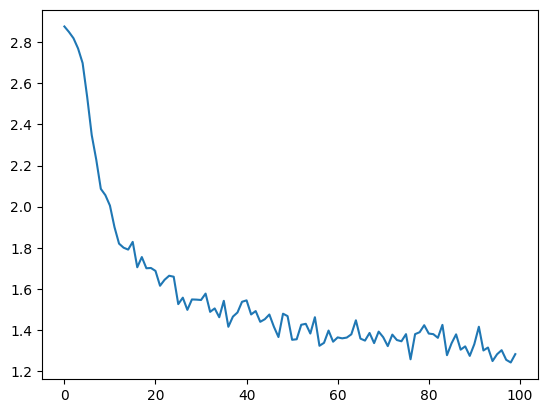

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Streaming output truncated to the last 5000 lines.
tensor([[-0.0510]], grad_fn=<TopkBackward0>) tensor([[7]])
tensor([[-1.3220]], grad_fn=<TopkBackward0>) tensor([[11]])
tensor([[-1.4769]], grad_fn=<TopkBackward0>) tensor([[14]])
tensor([[-0.0164]], grad_fn=<TopkBackward0>) tensor([[15]])
tensor([[-0.0527]], grad_fn=<TopkBackward0>) tensor([[17]])
tensor([[-1.2627]], grad_fn=<TopkBackward0>) tensor([[9]])
tensor([[-0.5444]], grad_fn=<TopkBackward0>) tensor([[7]])
tensor([[-0.1940]], grad_fn=<TopkBackward0>) tensor([[8]])
tensor([[-0.6212]], grad_fn=<TopkBackward0>) tensor([[3]])
tensor([[-0.8978]], grad_fn=<TopkBackward0>) tensor([[10]])
tensor([[-1.0916]], grad_fn=<TopkBackward0>) tensor([[13]])
tensor([[-1.0280]], grad_fn=<TopkBackward0>) tensor([[8]])
tensor([[-0.0688]], grad_fn=<TopkBackward0>) tensor([[1]])
tensor([[-0.2733]], grad_fn=<TopkBackward0>) tensor([[3]])
tensor([[-1.8350]], grad_fn=<TopkBackward0>) tensor([[12]])
tensor([[-0.5436]], grad_fn=<TopkBackward0>) tensor([[13]

<ipython-input-18-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-18-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


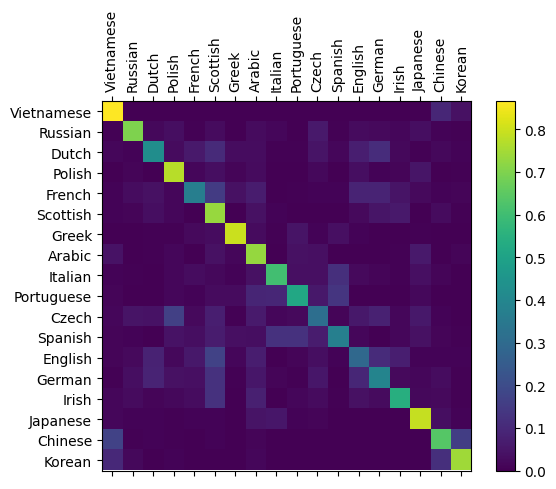

In [18]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [19]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.74) Czech
(-1.59) Russian
(-1.78) English

> Jackson
(-0.30) Scottish
(-2.14) English
(-2.57) Russian

> Satoshi
(-1.25) Japanese
(-1.51) Italian
(-1.53) Polish
